In [1]:
import glob, os

from marc_analysis import mode_colors, colortext_legend

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

import numpy as np
import pandas as pd
import xray

from utils import *

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load in some of the partial data from the actual simulation. We'll load the CSV data for simplicity, and find them all by using the `glob` module.

In [2]:
DATA_DIR = "arg_comp_ensemble/"
df = load_experiment(DATA_DIR, format='csv')
ds = load_experiment(DATA_DIR, format='nc')

Found 10 files
Reading...
    arg_comp_ensemble/single_timestep_ti_0000.csv
    arg_comp_ensemble/single_timestep_ti_0001.csv
    arg_comp_ensemble/single_timestep_ti_0002.csv
    arg_comp_ensemble/single_timestep_ti_0003.csv
    arg_comp_ensemble/single_timestep_ti_0004.csv
    arg_comp_ensemble/single_timestep_ti_0005.csv
    arg_comp_ensemble/single_timestep_ti_0006.csv
    arg_comp_ensemble/single_timestep_ti_0007.csv
    arg_comp_ensemble/single_timestep_ti_0008.csv
    arg_comp_ensemble/single_timestep_ti_0009.csv
Found 10 files
Reading...


What proportion of the modes correspond to the dominant activating mode at each iteration? We can do some summary statistics on this:

**First mode**

In [3]:
grouped_i1 = df.groupby('MODE_01')
n_i1 = grouped_i1.size()
pct_i1 = 100.*n_i1/len(df)
df_i1 = pd.DataFrame({'total': n_i1, 'pct': pct_i1})

print (df_i1)

               pct  total
MODE_01                  
ACC      96.495970  57473
DST01     0.142713     85
MBS       1.145064    682
MOS       2.216253   1320


**Second mode**

In [5]:
grouped_i2 = df.groupby(['MODE_01', 'MODE_02'])
n_i2 = grouped_i2.size() # this is a DataFrame!

# group by the first iteration
pct_i2 = n_i2.groupby(level=0) \
             .apply(lambda g: 100.*g/g.sum()) # compute the fraction of
                                              # of 2nd iter mode contribs
                                              # given that first iter mode

df_i2 = pd.DataFrame({'total': n_i2, 'pct': pct_i2})

print (df_i2)

                       pct  total
MODE_01 MODE_02                  
ACC     DST01     0.742958    427
        MBS      10.321368   5932
        MOS      36.164808  20785
        SSLT01   52.770866  30329
DST01   ACC      32.941176     28
        DST02    44.705882     38
        MOS      22.352941     19
MBS     ACC      36.070381    246
        DST01     0.586510      4
        MOS      63.343109    432
MOS     ACC      45.681818    603
        DST01     1.590909     21
        MBS      52.727273    696


So very clearly, the **ACC** mode is really important; 95% of the time it's the dominant mode. How often is it either the 1st- or 2nd-most important mode?

In [6]:
ACC_tot = n_i1.ix['ACC'] + n_i2.xs('ACC', level='MODE_02').sum()
#       ACC iter 1 total      n from iter 2 where MODE_02 == ACC
# alternatively: use `sel` from below
print( 100.*ACC_tot/n_i1.sum())

97.9684351914


... 97% of the time!

In [7]:
# Export mode data as JSON for sunburst viz

# 1) Construct the hierarchical dataset
from itertools import permutations
mode_names = ['AIT', 'ACC', 'MBS', 'MOS', 'DST01', 'DST02', 'SSLT01']
multi_labels = list(permutations(mode_names, 3))

full_index = pd.MultiIndex.from_tuples(multi_labels, 
                                       names=['MODE_01', 
                                              'MODE_02', 
                                              'MODE_03'])

data = df.groupby(['MODE_01', 'MODE_02', 'MODE_03']).size()
# PCT by LEVEL
# data_pct = data.groupby(level=0) \
#                .apply(lambda g: 100.*g/g.sum()) # compute the fraction of
#                                                 # of 2nd iter mode contribs
#                                                 # given that first iter mode
# PCT by ALL
data_pct = 100.*data/(np.sum(data))

data = pd.DataFrame({'pct': data_pct, 'count': data})
data_full = data.reindex(full_index, fill_value=0, copy=True)
mask = data_full['pct'] > 0.0

data_out = data_full[mask]
print (data_out)

                         count        pct
MODE_01 MODE_02 MODE_03                  
ACC     MBS     MOS       5782   9.707858
                DST01       26   0.043653
                SSLT01     124   0.208193
        MOS     MBS      15376  25.815984
                DST01      149   0.250168
                SSLT01    5260   8.831430
        DST01   MBS         88   0.147750
                MOS        149   0.250168
                DST02      187   0.313969
                SSLT01       3   0.005037
        SSLT01  MBS        776   1.302888
                MOS      29360  49.294829
                DST01        6   0.010074
MBS     ACC     MOS        235   0.394560
                DST01       11   0.018469
        MOS     ACC        428   0.718603
                DST01        4   0.006716
        DST01   ACC          3   0.005037
                MOS          1   0.001679
MOS     ACC     MBS        589   0.988919
                DST01        8   0.013432
                SSLT01       6   0

Which mode combinations add up to the most frequent dominating combinations?

In [9]:
mode3_sorted = data_out.sort('pct', ascending=False)

# Calculate cumulative percentage for the most frequent mode sets
mode3_sorted['cum_pct'] = mode3_sorted['pct'].cumsum()

print(mode3_sorted.head(10))
mode3_sorted.to_csv("mode3_sorted.csv")

# Combine the modes into parameter sets, and groupby to calculate
# percents for each common set
def combined_modes(row):
    modes = sorted([row['MODE_01'], row['MODE_02'], row['MODE_03']])
    short = ", ".join(modes)
    return short
m = (mode3_sorted
          .reset_index()
          [['MODE_01', 'MODE_02', 'MODE_03', 'pct']])
m['set'] = m.apply(combined_modes, axis=1)
cumulative = (m.groupby('set')
                 .sum()
                 .sort('pct', ascending=False)
                 .cumsum())
print(cumulative)

/Users/daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


                         count        pct    cum_pct
MODE_01 MODE_02 MODE_03                             
ACC     SSLT01  MOS      29360  49.294829  49.294829
        MOS     MBS      15376  25.815984  75.110813
        MBS     MOS       5782   9.707858  84.818670
        MOS     SSLT01    5260   8.831430  93.650101
        SSLT01  MBS        776   1.302888  94.952989
MOS     MBS     ACC        690   1.158496  96.111484
        ACC     MBS        589   0.988919  97.100403
MBS     MOS     ACC        428   0.718603  97.819006
        ACC     MOS        235   0.394560  98.213566
ACC     DST01   DST02      187   0.313969  98.527535
                          pct
set                          
ACC, MOS, SSLT01    58.136333
ACC, MBS, MOS       96.920752
ACC, MBS, SSLT01    98.431833
ACC, DST01, MOS     98.962391
ACC, DST01, DST02   99.365346
ACC, DST01, MBS     99.580255
DST01, DST02, MOS   99.625588
DST01, MBS, MOS     99.670920
ACC, DST01, SSLT01  99.686031


Trace the average error in $S_\text{max}$ as each mode is added

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


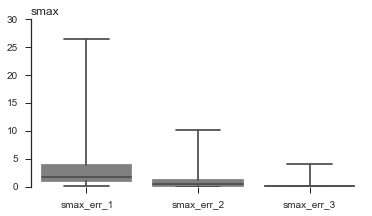

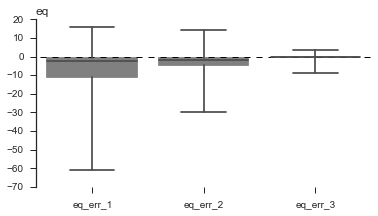

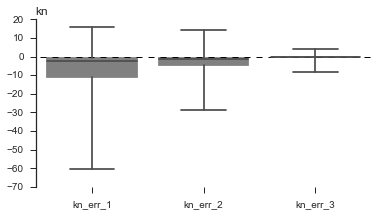

In [12]:
# Compute relative error in Smax for first three iters
df_err = df.copy(deep=True)
for i in [1, 2, 3]:
    smax_all, eq_all, kn_all = df['SMAX_all'], df['EQ_all'], df['KN_all']
    smax_iter, eq_iter, kn_iter = df['SMAX_%02d' % i], df['EQ_%02d' % i], \
                                  df['KN_%02d' % i]
    df_err['smax_err_%d' % i] = 100.*(smax_iter - smax_all)/smax_all
    df_err['eq_err_%d' % i] = 100.*(eq_iter - eq_all)/eq_all
    df_err['kn_err_%d' % i] = 100.*(kn_iter - kn_all)/kn_all
df_err[df_err == np.inf] = np.nan
df_err.dropna(inplace=True)

for s in ['smax', 'eq', 'kn']:
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(111)

    rel_errs = df_err[[s+'_err_%d' % i for i in [1,2,3]]]
    ax.hlines(0, -1, 3, lw=1, linestyle='dashed')
    sns.boxplot(rel_errs, color='grey', whis=[1., 99.], showfliers=False)
#     ax.set_ylim(-30, 30)
    sns.despine(ax=ax, bottom=True)
    ax.set_title(s, loc='left')

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


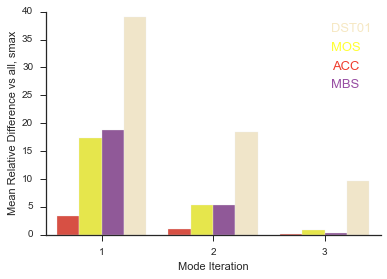

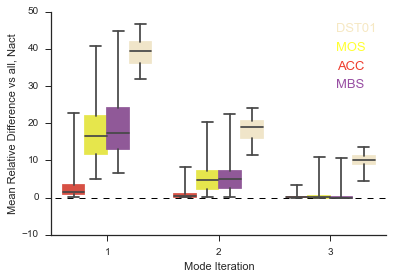

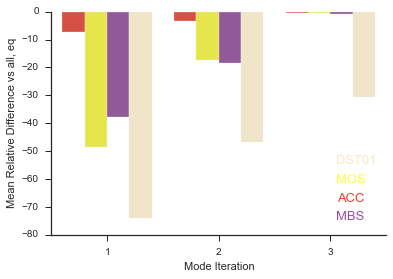

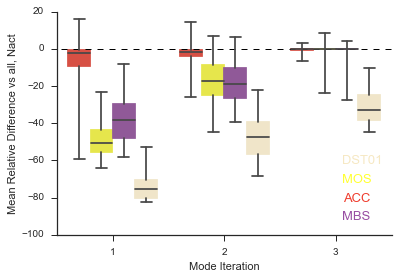

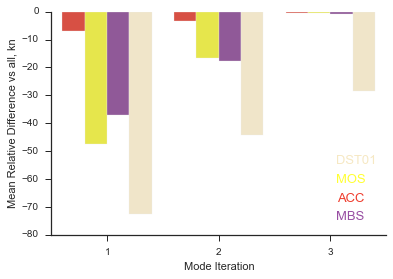

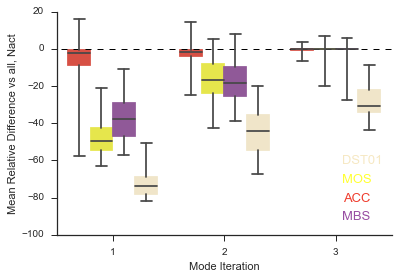

In [13]:
for s in ['smax', 'eq', 'kn']:
    
    tidy_df_err = pd.melt(df_err, id_vars=['MODE_01', 'MODE_02', 'MODE_03'], 
                          value_vars=[s+'_err_1', s+'_err_2', s+'_err_3'])

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)

    # Extract just the mode colors in the plot
    colors = {mode: mode_colors[mode] 
              for mode in pd.unique(tidy_df_err['MODE_01'])}

    sns.barplot(x='variable', y='value', data=tidy_df_err, hue='MODE_01',
                ci=None, palette=colors, ax=ax)

    ax.set_xlabel("Mode Iteration")
    ax.set_xticklabels([1, 2, 3])
    ax.set_ylabel("Mean Relative Difference vs all, " + s)
    colortext_legend(colors, ax=ax, fontsize=13, loc='best')
    sns.despine(ax=ax)

    plt.savefig("figs/iter_%s_re.png" % s, transparent=True, dpi=300)
    
    #################################################################
    
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)

    sns.boxplot(x='variable', y='value', data=tidy_df_err, hue='MODE_01',
                whis=[1., 99.], showfliers=False, palette=colors, ax=ax)
    ax.hlines(0, -1, 4, lw=1, linestyle='dashed')

    ax.set_xlabel("Mode Iteration")
    ax.set_xticklabels([1, 2, 3])
    ax.set_ylabel("Mean Relative Difference vs all, Nact")
    colortext_legend(colors, ax=ax, fontsize=13, loc='best')
    sns.despine(ax=ax)

    plt.savefig("figs/iter_nact_%s_box.png" % s, transparent=True, dpi=300)

How does the total number of activated aerosol using each iterative modal estimate for Smax change per iteration? This wasn't part of the original analysis, so the script `iter_activation.py` was created to compute the results which were saved and moved to **arg_comp_ensemble/iter_nact.csv**. We can directly merge this into the results to study.

In [14]:
iter_act = pd.read_csv("arg_comp_ensemble/iter_nact.csv", index_col=0)
combined_data = pd.concat([df, iter_act], axis=1)

# Compute relative error in Smax for first three iters
for i in [1, 2, 3]:
    nact_all = combined_data['EQ_all']
    nact_iter = combined_data['N_ACT_%02d' % i]
    df_err['nact_err_%d' % i] = 100.*(nact_iter - nact_all)/nact_all
df_err[df_err == np.inf] = np.nan
df_err.dropna(inplace=True)

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


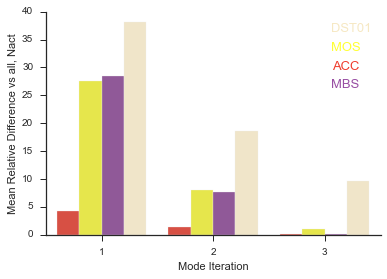

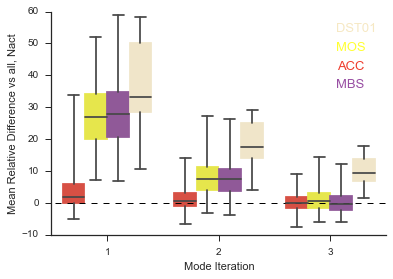

In [15]:
tidy_df_err = pd.melt(df_err, id_vars=['MODE_01', 'MODE_02', 'MODE_03'], 
                      value_vars=['nact_err_1', 'nact_err_2', 
                                  'nact_err_3'])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

# Extract just the mode colors in the plot
colors = {mode: mode_colors[mode] 
          for mode in pd.unique(tidy_df_err['MODE_01'])}

sns.barplot(x='variable', y='value', data=tidy_df_err, hue='MODE_01',
            ci=None, palette=colors, ax=ax)

ax.set_xlabel("Mode Iteration")
ax.set_xticklabels([1, 2, 3])
ax.set_ylabel("Mean Relative Difference vs all, Nact")
colortext_legend(colors, ax=ax, fontsize=13, loc='best')
sns.despine(ax=ax)

plt.savefig("figs/iter_nact_re.png", transparent=True, dpi=300)

####

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

# Extract just the mode colors in the plot
colors = {mode: mode_colors[mode] 
          for mode in pd.unique(tidy_df_err['MODE_01'])}

sns.boxplot(x='variable', y='value', data=tidy_df_err, hue='MODE_01',
            whis=[1., 99.], showfliers=False, palette=colors, ax=ax)
ax.hlines(0, -1, 4, lw=1, linestyle='dashed')

ax.set_xlabel("Mode Iteration")
ax.set_xticklabels([1, 2, 3])
ax.set_ylabel("Mean Relative Difference vs all, Nact")
colortext_legend(colors, ax=ax, fontsize=13, loc='best')
sns.despine(ax=ax)

plt.savefig("figs/iter_nact_re_box.png", transparent=True, dpi=300)


Where do these different dominant activations occur? 

In [16]:
# Jitter the lat/lon coordinates to represent sampling from gridboxes,
# which in these simulations were 2.5 x 1.9 degrees
dlon, dlat = 2.5, 1.9
npoints = len(df)
df_map = df.copy()

lev_array = np.array(sorted(df_map.lev.unique()))

def rand_fact(npoints, width):
    """ Rescale a number from [0, 1) to [-width, width) """
    points = 2.*np.random.random(npoints) - 1. 
    points *= width
    return points

l1 = df_map['lon'].copy()
l2 = df_map['lat'].copy()

df_map['lon'] = df_map['lon'] + rand_fact(npoints, dlon/2.)
df_map['lat'] = df_map['lat'] + rand_fact(npoints, dlat/2.)

# Create a true DataSet by converting the lat, lon, lev, time
# columns to indices and then dimensions
df_inds = df.set_index(['lat', 'lev', 'lon', 'time'], 
                       verify_integrity=True)
ds_inds = xray.Dataset.from_dataframe(df_inds)

In [118]:
mode1_map = ds_inds['MODE_01']
v = mode1_map.values

def get_mode_counts(mode, dims=['time', 'lev']):
    """ """
    mode_map = mode1_map.copy()
    mode_map.values[v == mode] = 1
    mode_map.values[v != mode] = 0
    counts = mode_map.sum(dims)
    
    return counts

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/numpy/lib/shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/numpy/lib/shape_base.py:431: FutureWarning: in the future np.array_split will retain the shape of arrays with a zero size, instead of replacing them by `array([])`, which always has a shape of (0,).
  FutureWarning)
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar

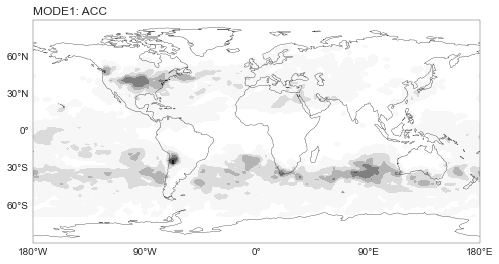

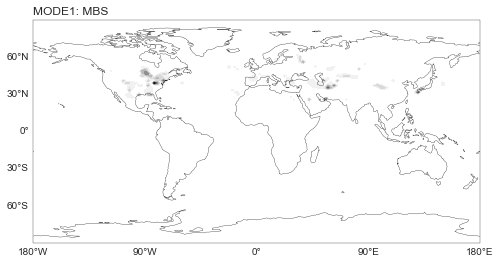

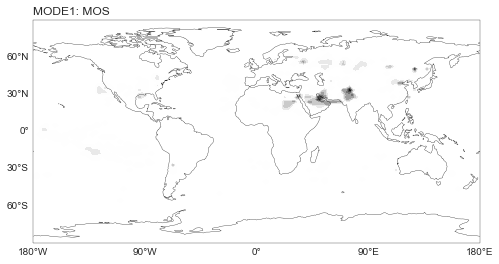

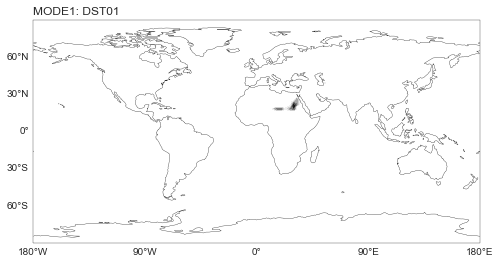

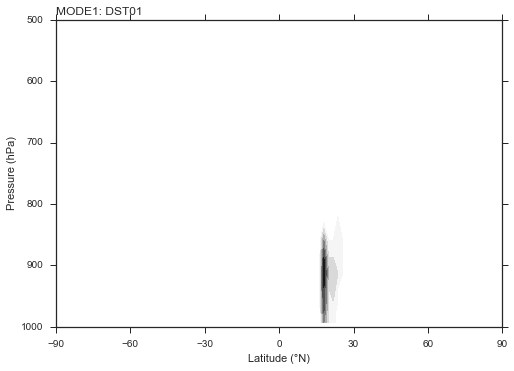

In [126]:
from marc_analysis.plot import geo_plot, vertical_plot

for mode in ["ACC", "MBS", "MOS", "DST01"]:
    mode_flat = get_mode_counts(mode)
    mode_hi = get_mode_counts(mode, dims=['time', 'lon'])
    # print(mode, mode_flat.max(), mode_hi.max())
    
    ax, _ = geo_plot(mode_flat, method='contourf', vmin=1)
    ax.set_title("MODE1: %s" % mode, loc='left')
    plt.savefig("figs/%s_flat_mode1_dist.png" % mode, 
                dpi=300, transparent=False)
    
    ax, _ = vertical_plot(mode_hi.T, top=500, vmin=1)
    ax.set_title("MODE1: %s" % mode, loc='left')
    plt.savefig("figs/%s_vert_mode1_dist.png" % mode, 
                dpi=300, transparent=False)

---

How many second-mode particles do there need to be to impact $\Delta S_\text{max}$ and $\Delta N_\text{act}$ when ACC is the dominant mode?

In [74]:
iter_act = pd.read_csv("arg_comp_ensemble/iter_nact.csv", index_col=0)
combined_data = pd.concat([df, iter_act], axis=1)

mode2 = "DST01"
var = "SMAX"

# Select cases where ACC dominated
acc = combined_data[combined_data.MODE_01 == 'ACC']
mode1 = acc[acc.MODE_02 == mode2]

dvar1 = mode1[var+'_01'] - mode1[var+'_04'] # Could use 'all' instead of '04'
dvar2 = mode1[var+'_02'] - mode1[var+'_04']

# sns.regplot(np.log10(mode1['n'+mode2]), np.log10(dvar1 - dvar2))
# plt.figure()
# sns.regplot(np.log10(mode1['SMAX_01']) ,np.log10(dvar1 - dvar2))

In [86]:
for mode in ["ACC", "AIT", "MOS", "MBS", "DST01", "SSLT01"]:
    n = df['n'+mode]
    print("  {:>10s} {:1.3e} {:1.3e}".format(mode, n.min(), n.max()))

         ACC 1.022e+00 8.370e+03
         AIT 1.000e+00 5.225e+04
         MOS 1.000e+00 7.010e+03
         MBS 1.000e+00 1.547e+04
       DST01 3.259e-27 5.732e+02
      SSLT01 2.593e-09 2.671e+00


Found 427 cases of ACC -> DST01
Found 30329 cases of ACC -> SSLT01
Found 5932 cases of ACC -> MBS
Found 20785 cases of ACC -> MOS


/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


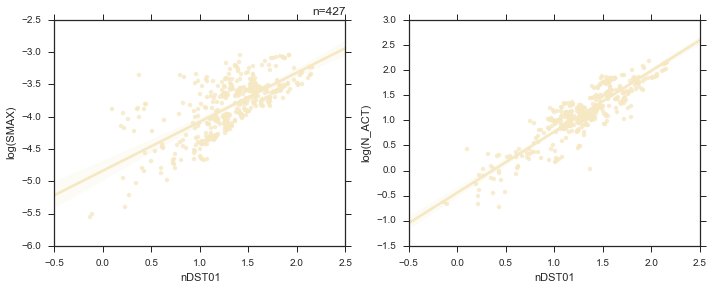

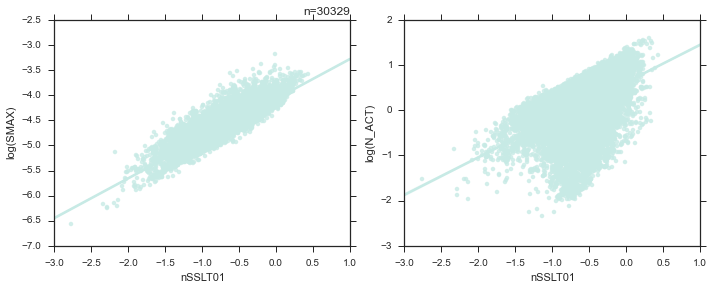

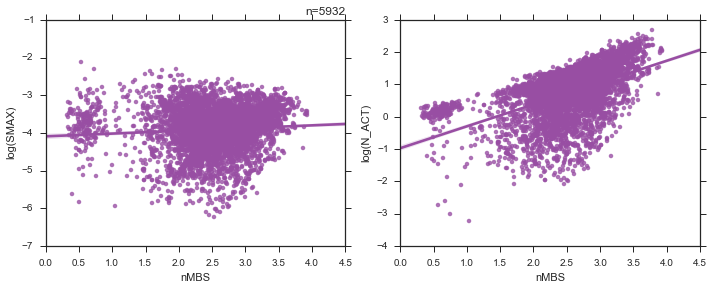

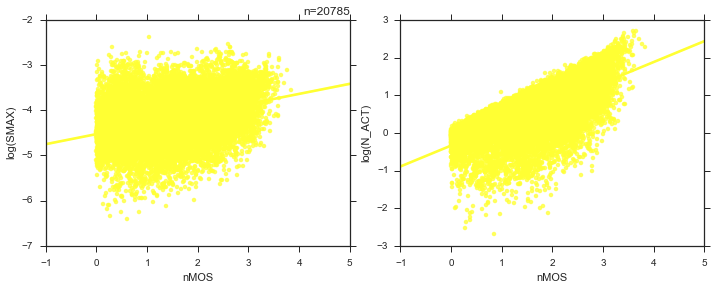

In [76]:
iter_act = pd.read_csv("arg_comp_ensemble/iter_nact.csv", index_col=0)
combined_data = pd.concat([df, iter_act], axis=1)

def mode2_bias(mode2, log=True):
    
    # Select cases where ACC dominated
    acc = combined_data[combined_data.MODE_01 == 'ACC']
    mode2_data = acc[acc.MODE_02 == mode2]

    print("Found {:d} cases of ACC -> {:s}".format(len(mode2_data), mode2))
    
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    color = mode_colors[mode]

    for ax, var in zip(axs, ["SMAX", "N_ACT"]):
    
        dvar1 = mode2_data[var+'_01'] - mode2_data[var+'_04'] # Could use 'all' instead of '04'
        dvar2 = mode2_data[var+'_02'] - mode2_data[var+'_04']

        x = mode2_data['n'+mode2]
        y = dvar1 - dvar2
        if log:
            x = np.log10(x)
            y = np.log10(y)
        sns.regplot(x, y, ax=ax, color=color)
    
        varl = "log(%s)" % var if log else varl
        ax.set_ylabel(varl)
        
    plt.tight_layout()
    
    ax = axs[0]
    ax.set_title("n=%d" % len(dvar1), loc='right')
    
    return fig

for mode in ["DST01", "SSLT01", "MBS", "MOS",]:
    fig = mode2_bias(mode)
    plt.savefig("figs/mode1_acc_bias_%s.png" % mode)

---

# DEPRECATED

Everything below here is old. Saving for now, but it should be spliced off into a different analysis, most likely.

In [7]:
from collections import OrderedDict as od

# Create JSON to write to disk
m1_children = []
m1s = set(data_out.index.get_level_values(0))
for m1 in sorted(m1s):
    m2s = set(data_out.ix[m1].index.get_level_values(0))

    m2_children = []
    for m2 in sorted(m2s):
        m3s = set(data_out.ix[m1,m2].index.get_level_values(0))                
        m3_children = [ { 'name': m3,
                          'size': int(data_out.ix[m1,m2,m3]['count']) } 
                       for m3 in sorted(m3s) ]
        
        m2_children.append( { 'name': m2, 'children': m3_children })
    m1_children.append( { 'name': m1, 'children': m2_children } )

data_json = {'name': 'mode_data', 'children': m1_children}

import json
with open("mode.json", "wb") as f:
    json.dump(data_json, f)
    
import pprint
pprint.pprint(data_json)

{'children': [{'children': [{'children': [{'name': 'DST02', 'size': 187},
                                          {'name': 'MBS', 'size': 88},
                                          {'name': 'MOS', 'size': 149},
                                          {'name': 'SSLT01', 'size': 3}],
                             'name': 'DST01'},
                            {'children': [{'name': 'DST01', 'size': 26},
                                          {'name': 'MOS', 'size': 5782},
                                          {'name': 'SSLT01', 'size': 124}],
                             'name': 'MBS'},
                            {'children': [{'name': 'DST01', 'size': 149},
                                          {'name': 'MBS', 'size': 15376},
                                          {'name': 'SSLT01',
                                           'size': 5260}],
                             'name': 'MOS'},
                            {'children': [{'name': 'DST01', 'size': 6},
          

/Users/daniel/anaconda/lib/python2.7/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


Is there something special about the situations where **ACC** *isn't* one of the two most important modes? We can split the original dataset into two segments and visualize using a `factorplot` on that identifier.

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


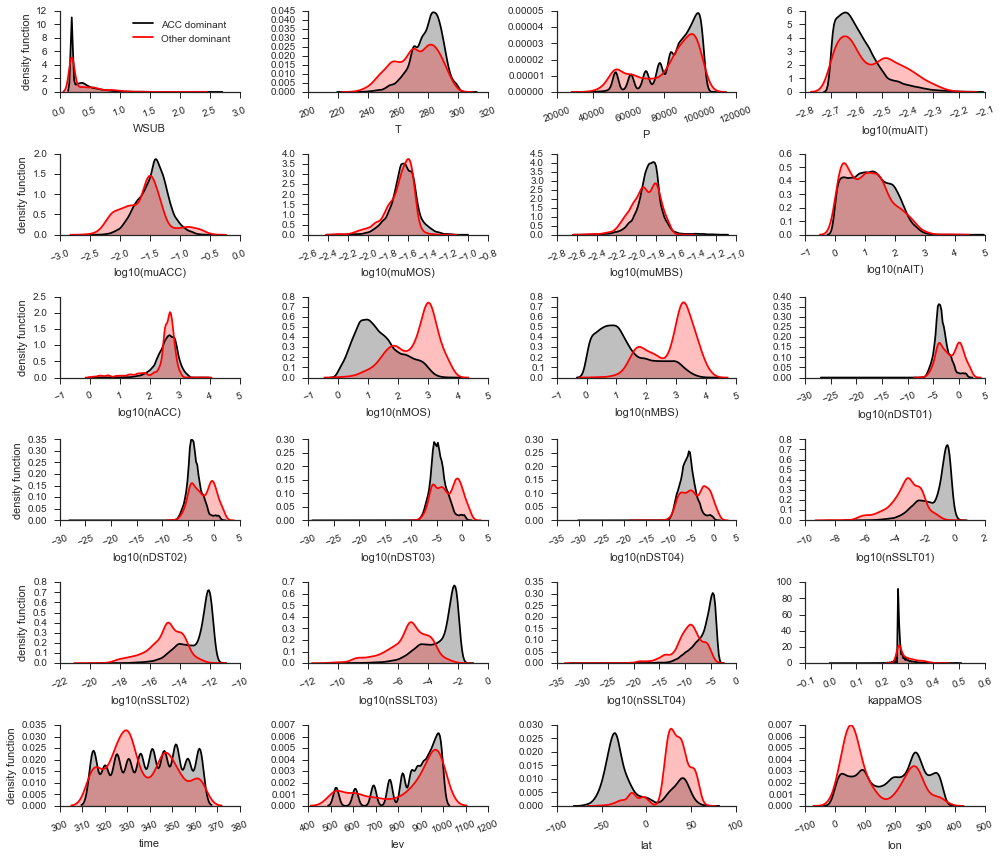

In [220]:
#sel = (df['MODE_01'] == 'ACC') | (df['MODE_02'] == 'ACC')
sel = df['MODE_01'] == 'ACC'
yes_ACC = df[sel]
no_ACC = df[~sel]

# Label the samples based on of ACC was in the first two iters
df['ACC_important'] = True
df.loc[~sel, 'ACC_important'] = False

# Plot KDEs of each of the parameters, split along ACC_important
keys = [k for k in df.keys() if not "_" in k]
n_plots = len(keys)
n_cols = 4
n_rows = int(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*2))
for i, (key, ax) in enumerate(zip(keys, axs.ravel())):
    
    kde_args = dict(ax=ax, shade=True)
    if i > 0: kde_args['legend'] = False
    
    df_ACC, df_other = df.loc[sel, key], df.loc[~sel, key]
    if key.startswith("n") or key.startswith("mu"):
        df_ACC = np.log10(df_ACC)
        df_other = np.log10(df_other)
        key = "log10(%s)" % key
    try:
        sns.kdeplot(df_ACC, label="ACC dominant", 
                    color='k', **kde_args)
        sns.kdeplot(df_other, label="Other dominant",
                    color='r', **kde_args)
    except:
        print('something broke')
    
    ax.set_xlabel(key)
    plt.setp(ax.get_xticklabels(), rotation=20)
    #labels = [t.get_text() for t in ax.get_xticklabels()]
    #ax.set_xticklabels(labels, rotation=45)
    
    if (i % n_cols) == 0:
        ax.set_ylabel("density function")

sns.despine(fig=fig)
plt.tight_layout()
plt.savefig("figs/param_dens_vs_ACC_dom.png")

A couple things stand out, ranked form *curious* to *obvious* -

1. **ACC** dominates more often in the SH than the NH, but the *opposite* is true for when other modes dominate. Does this have something to do with inter-hemispheric differences in the aerosol size distributions and other factors identified below?

2. Generally speaking, when **other** modes dominate, ACC there are (a) *fewer* ACC particles, and (b) *smaller* ACC particles. This is likely because the size distribution moments have a strong positive correlation? 

3. The opposite is true for MBS/MOS. When ACC doesn't dominate, they tend to be *smaller* but *more numerous*. Do the same correlations between moments exit for these two modes?

The next few analyses dig into these questions.

## 1) Splitting by hemisphere

hemisphere
NH    18264
SH    41296
dtype: int64
WSUB
T
P
muAIT
muACC
muMOS
muMBS
nAIT
nACC
nMOS
nMBS
nDST01
nDST02
nDST03
nDST04
nSSLT01
nSSLT02
nSSLT03
nSSLT04
kappaMOS


/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


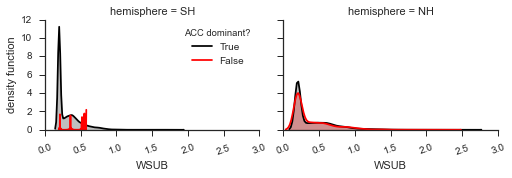

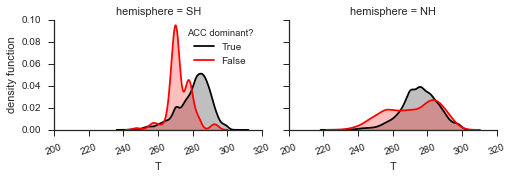

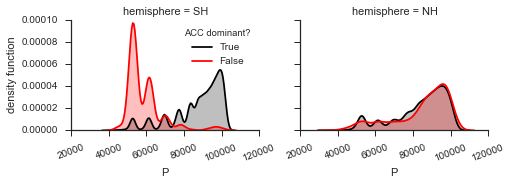

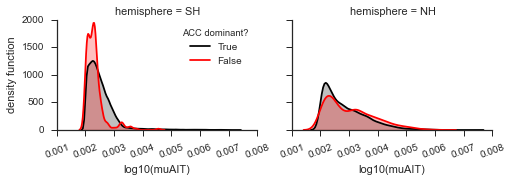

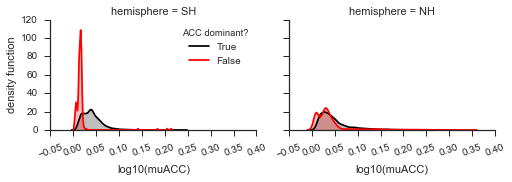

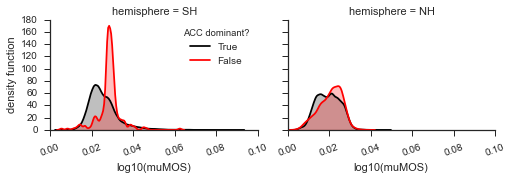

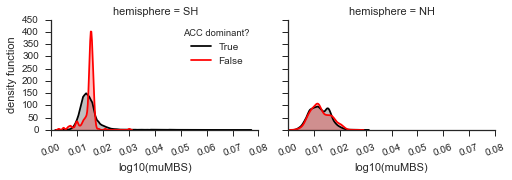

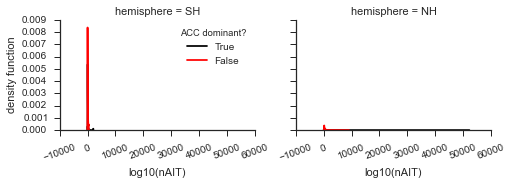

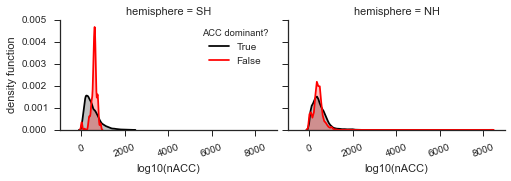

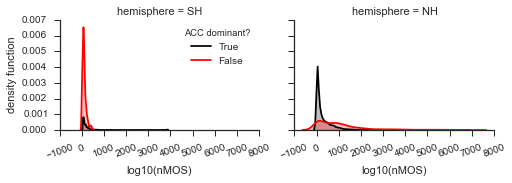

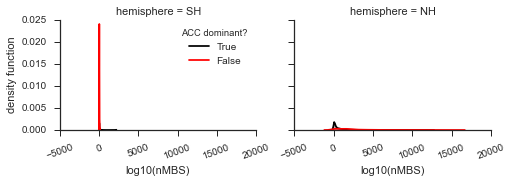

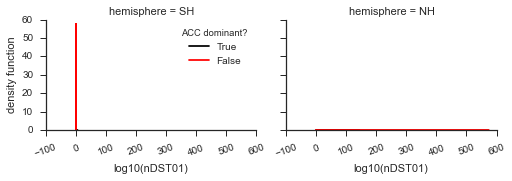

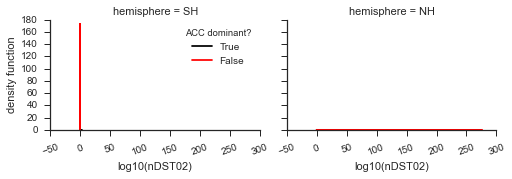

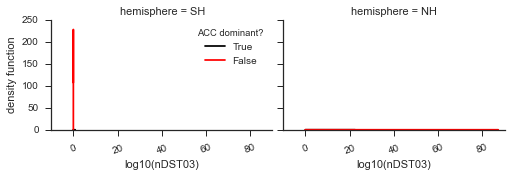

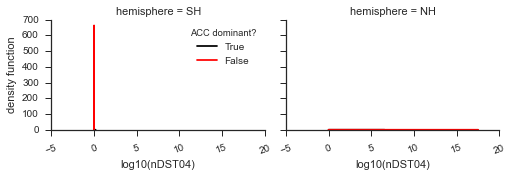

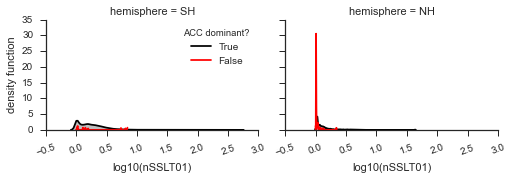

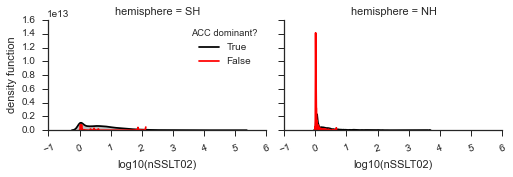

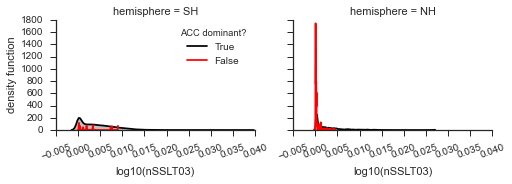

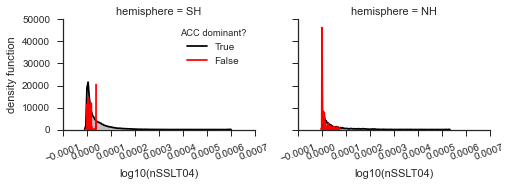

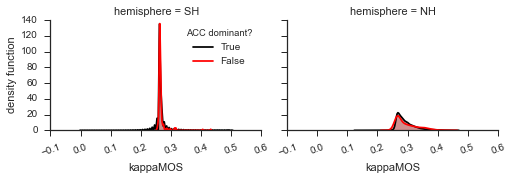

In [11]:
sel_sh = df['lat'] < 0.
df['hemisphere'] = 'NH'
df.loc[sel_sh, 'hemisphere'] = 'SH'

n_hemi = df.groupby('hemisphere').size()
print (n_hemi)

for key in keys:
    if key in ['lat', 'lev', 'lon', 'time']: continue
    
    df_trunc = df[['hemisphere', 'ACC_important', key]]
    if key.startswith("n") or key.startswith("mu"):
        df_trunc[key] = np.log10(df_trunc[key])
        label = "log10(%s)" % key
    else: label = key
    
    print(key)
    with sns.color_palette(['k', 'r']):
        g = sns.FacetGrid(df, col='hemisphere', hue='ACC_important', legend_out=False,
                          size=2.5, aspect=3.5/2.5, hue_order=[True, False])
        g.map(sns.kdeplot, key, shade=True)
        g.add_legend(title="ACC dominant?")
        g.set_ylabels("density function")
        g.set_xlabels(label)
        g.set_xticklabels(rotation=20)
        

Splitting by hemisphere doesn't really change anything; there aren't any wildly different distributions in the input parameters and the ensuing dominant mode. Obviously in the NH, we prove colder temperatures. What's curious is the preponderance of SH vs NH samples; why should there be more valid samples from the SH than the NH? This is worth considering a bit more. First, let's try to plot some sort of heatmap of where the parameter samples came from.

In [9]:
# Jitter the lat/lon coordinates to represent sampling from gridboxes,
# which in these simulations were 2.5 x 1.9 degrees
dlon, dlat = 2.5, 1.9
npoints = len(df)
df_map = df.copy()

def rand_fact(npoints, width):
    """ Rescale a number from [0, 1) to [-width, width) """
    points = 2.*np.random.random(npoints) - 1. 
    points *= width
    return points

l1 = df_map['lon'].copy()
l2 = df_map['lat'].copy()

df_map['lon'] = df_map['lon'] + rand_fact(npoints, dlon/2.)
df_map['lat'] = df_map['lat'] + rand_fact(npoints, dlat/2.)

lon, lat = df_map.lon, df_map.lat
# # Correct lon: 
# # 1) some values may be < 0 or > 360, map these into [0, 360]
# lon[lon < 0] = lon[lon < 0] + 360.
# lon[lon > 360] = lon[lon > 360] - 360.
# # 2) map from [0, 360] -> [-180, 180]
# lon -= 180.

df_map['lon'] = lon[:]

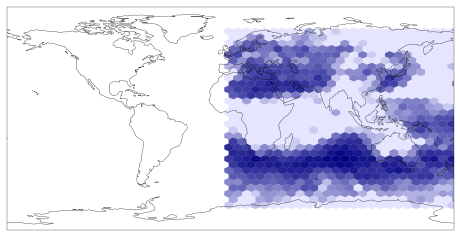

In [10]:
import cartopy.crs as ccrs
import cartopy.feature

lon, lat = df_map.lon, df_map.lat
# Correct lon: 
# 1) some values may be < 0 or > 360, map these into [0, 360]
# lon[lon < 0] = lon[lon < 0] + 360.
# lon[lon > 360] = lon[lon > 360] - 360.
# # 2) map from [0, 360] -> [-180, 180]
# lon -= 180.

proj = ccrs.PlateCarree()
cmap = sns.light_palette("navy", 12, as_cmap=True)

with sns.color_palette("Reds"):
    ax = plt.axes(projection=proj)
    hb = ax.hexbin(lon, lat, gridsize=(50, 15), bins='log', 
                   transform=proj, cmap=cmap)
    ax.coastlines()
    ax.set_global()

It's not immediately obvious why we'd have see this separation between the two hemispheres. However, given that we're over-sampling remote maritime conditions, an obvious hypothesis would be bias in the $\mu$-$N$ relationships for the sulfate and mixed modes. If increasing $N$ tends to decrease $\mu$ below our cutoff threshholds, then we could be in for some trouble! We should explicitly plot those relationships for the four modes, segregating by hemisphere.

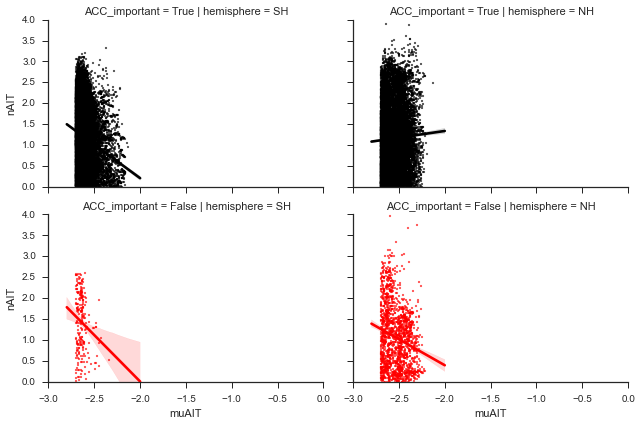

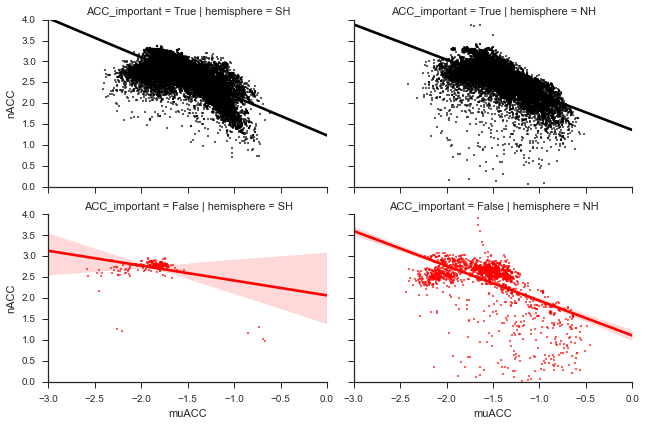

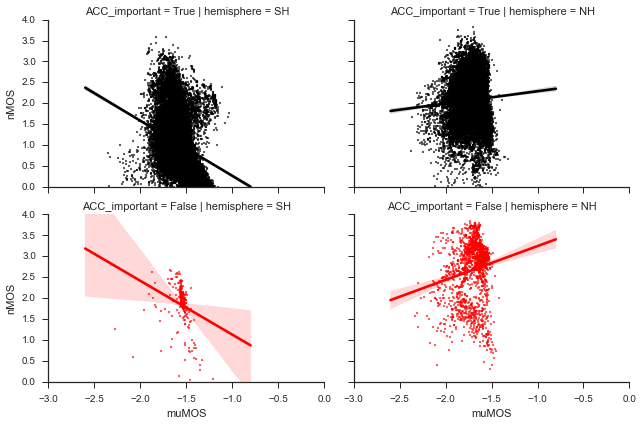

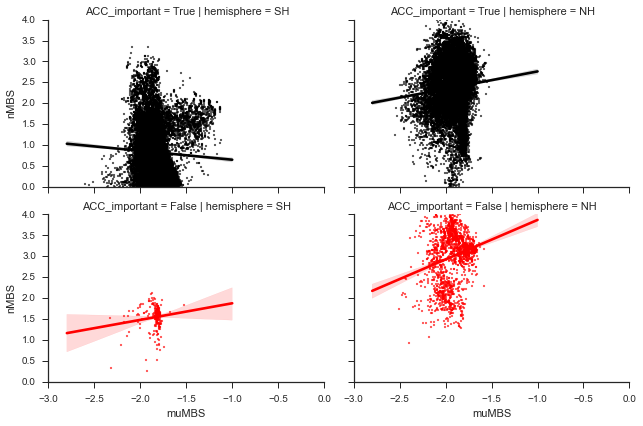

In [15]:
## Regressions
modes = ['AIT', 'ACC', "MOS", "MBS"]
df_aero = df[['mu%s' % m for m in modes] + ['n%s' % m for m in modes]] 
df_aero = np.log10(df_aero)
df_aero['hemisphere'] = df['hemisphere']
df_aero['ACC_important'] = df['ACC_important']

for mode in modes:
    with sns.color_palette(['k', 'r']):
        g = sns.lmplot('mu'+mode, 'n'+mode, df_aero, 
                       row='ACC_important', col='hemisphere', hue='ACC_important',
                       size=3., aspect=1.5, 
                       markers='.', scatter_kws=dict(alpha=0.7))
        
        for ax in g.axes.ravel():
            ax.set_ylim(0, 4)
            ax.set_xlim(-3, 0)

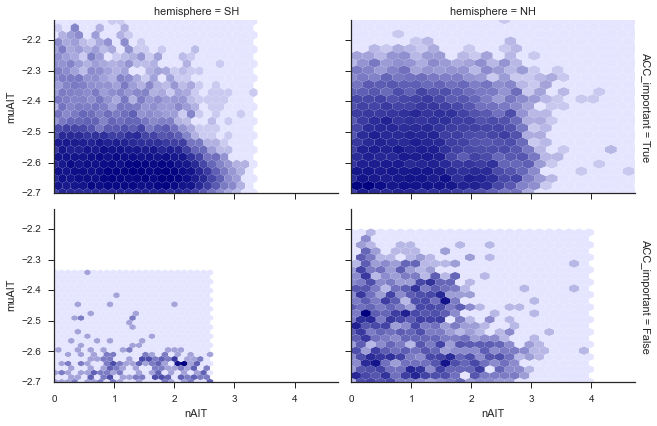

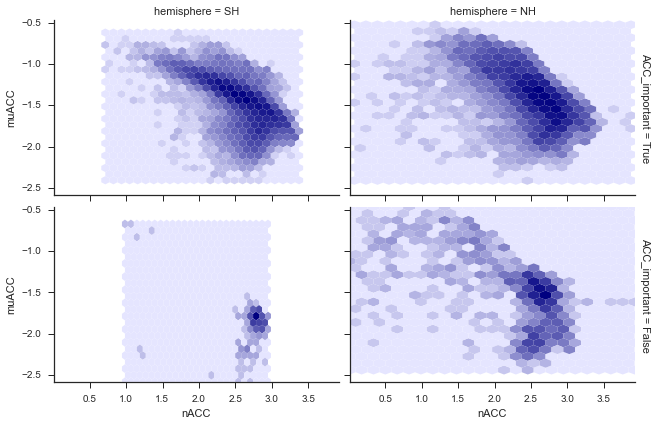

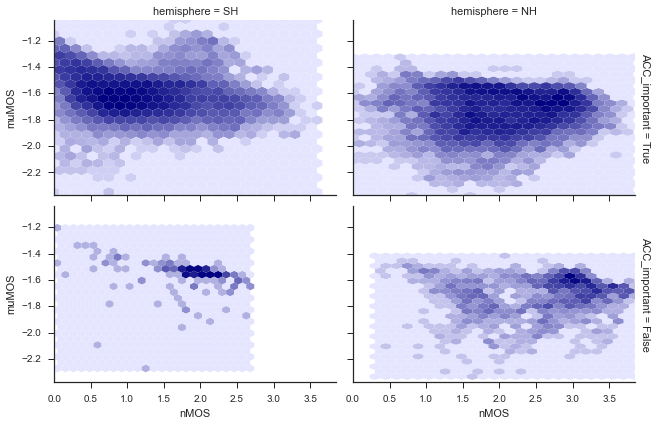

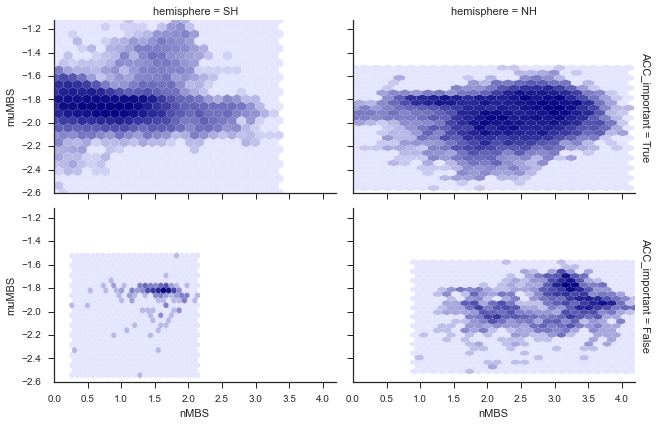

In [16]:
## Distributions
cmap = sns.light_palette("navy", 12, as_cmap=True)

for mode in modes: 
    g = sns.FacetGrid(df_aero, row='ACC_important', col="hemisphere",
                      size=3, aspect=1.5, margin_titles=True)
    g.map(plt.hexbin, 'n'+mode, 'mu'+mode, gridsize=(24, 12), edgecolor='none',
          bins='log', cmap=cmap)

So there are definitely some non-trivial differences between the aerosol in the NH/SH. But it's probably better to focus on the whole rather than break it into the parts that I've done here.

---

## $\Delta$Smax, $\Delta$Nact

Is $\Delta$Smax impacted by whether or not ACC is important?

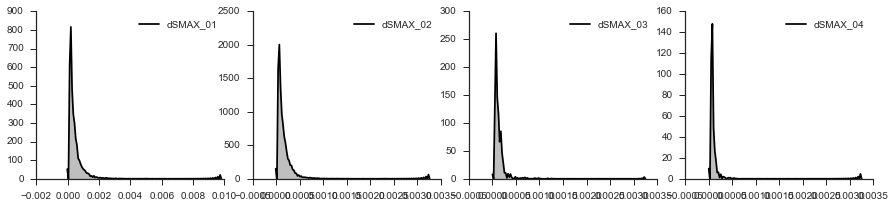

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for i in xrange(1, 5):
    i_str = "%02d" % i
    df['dSMAX_' + i_str] = df['SMAX_' + i_str] - df['SMAX_all']
    ax = axs.ravel()[i-1]
    sns.kdeplot(df['dSMAX_%02d' % i], ax=ax, shade=True, color='k',
                label=None)
sns.despine(fig)

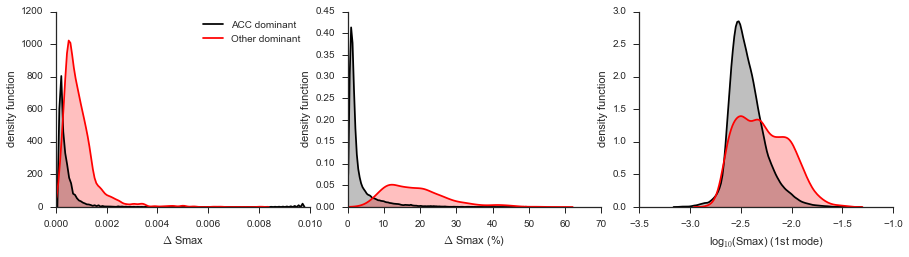

In [20]:
sel = df['MODE_01'] == 'ACC'

kwargs = dict(shade=True)

# Smax - raw
df_ACC, df_other = df.loc[sel, 'dSMAX_01'], df.loc[~sel, 'dSMAX_01']

fig = plt.figure(figsize=(15, 3.5))
ax = fig.add_subplot(131)
kwargs['ax'] = ax

sns.kdeplot(df_ACC, label="ACC dominant", color='k', **kwargs)
sns.kdeplot(df_other, label="Other dominant", color='r', **kwargs)
sns.despine(fig)
ax.set_xlabel("$\Delta$ Smax")
ax.set_ylabel("density function")
ax.set_xlim(0)

# Smax - percent
df_ACC = 100.*df.loc[sel, 'dSMAX_01']/df.loc[sel, 'SMAX_all']
df_other = 100.*df.loc[~sel, 'dSMAX_01']/df.loc[~sel, 'SMAX_all']

ax = fig.add_subplot(132)
kwargs['ax'] = ax
kwargs['legend'] = False

sns.kdeplot(df_ACC, label="ACC dominant", color='k', **kwargs)
sns.kdeplot(df_other, label="Other dominant", color='r', **kwargs)
sns.despine(fig)
ax.set_xlabel("$\Delta$ Smax (%)")
ax.set_ylabel("density function")
ax.set_xlim(0)

# As a reference, also plot the distribution of Smax (1)
df_ACC, df_other = np.log10(df.loc[sel, 'SMAX_01']), np.log10(df.loc[~sel, 'SMAX_01'])

ax = fig.add_subplot(133)
kwargs['ax'] = ax

sns.kdeplot(df_ACC, label="ACC dominant", color='k', **kwargs)
sns.kdeplot(df_other, label="Other dominant", color='r', **kwargs)
sns.despine(fig)
ax.set_xlabel("log$_{10}$(Smax) (1st mode)")
ax.set_ylabel("density function")


In [19]:
from bokeh import mpl
from bokeh.plotting import show, output_notebook
from IPython import display

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


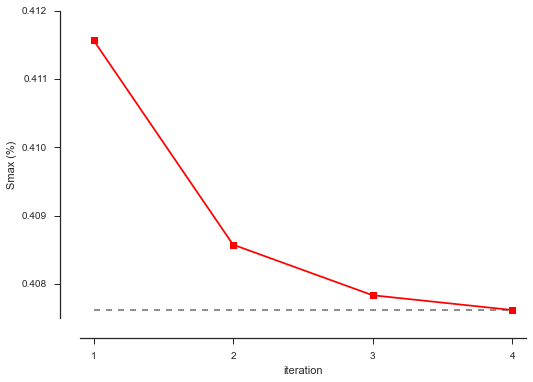

In [22]:
r = df.ix[100]
keys = ['SMAX_01', 'SMAX_02', 'SMAX_03', 'SMAX_04']
idx = np.array(range(1, len(keys)+1))

r_smax = r[keys]*100.
plt.plot(idx, r_smax, marker='s', color='r')
plt.hlines(r['SMAX_all']*100., idx[0], idx[-1],
           alpha=0.5, linestyle='--')
plt.xticks(idx)
plt.xlim(idx[0]-0.1, idx[-1]+0.1)

plt.ylabel("Smax (%)")
plt.xlabel("iteration")
sns.despine(offset=20)
